In [1052]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

if os.getcwd() == '/Users/cd8607/Documents/Fitting_Potential':
    pass
else:
    os.chdir('../')

whe = np.loadtxt('Potentials/W-He-Juslin.table',skiprows=6)[:,1:3]


class ZBL():

    def __init__(self, Zi, Zj):
        
        self.Zi = Zi
        self.Zj = Zj

        e0 = 55.26349406e-4

        K = 1/(4*np.pi*e0)

        self.a = 0.46850/(self.Zi**0.23 + self.Zj**0.23)	

        self.amplitude = np.array([0.18175, 0.50986, 0.28022, 0.02817])
        self.exponent = np.array([3.19980, 0.94229, 0.40290, 0.20162])

        self.constant = K*Zi*Zj

    def eval_zbl(self, rij):

        x = rij/self.a

        x = x[:, np.newaxis]

        phi = np.sum(self.amplitude * np.exp(-self.exponent * x), axis=1)
            
        return (self.constant/rij)*phi
    
    def eval_grad(self, rij):

        x = rij/self.a

        x = x[:, np.newaxis]

        phi = np.sum(self.amplitude * np.exp(-self.exponent * x), axis=1)
        
        dphi = np.sum(-self.amplitude*self.exponent * np.exp(-self.exponent * x), axis=1)

        return (self.constant/rij)*(dphi/self.a - phi/rij)
    
    def eval_hess(self, rij):
        
        x = rij/self.a

        x = x[:, np.newaxis]

        phi = np.sum(self.amplitude * np.exp(-self.exponent * x), axis=1)
        
        dphi = np.sum(-self.amplitude*self.exponent * np.exp(-self.exponent * x), axis=1)

        d2phi = np.sum(self.amplitude*self.exponent**2 * np.exp(-self.exponent * x), axis=1)

        return (self.constant/rij)*(d2phi/self.a**2 - 2*dphi/(self.a*rij) + 2*phi/rij**2)


In [1053]:
class Polynomial_PairPot():

    def __init__(self, Zi, Zj, eam = False, n_knots = 1, beta = 1, r_0 = 0,r_cutoff = 4.8513889200):

        self.n_knots = n_knots

        self.x_knot = np.linspace(r_0, r_cutoff, 2 + n_knots)

        self.beta = beta

        zbl = ZBL(Zi,Zj)

        self.y_zbl = zbl.eval_zbl(self.x_knot)

        self.dy_zbl = zbl.eval_grad(self.x_knot)

        self.d2y_zbl = zbl.eval_hess(self.x_knot)

        self.eam = eam

    def rand_sample_points(self):
        
        n_sigma = 5

        y_sigma_arr = np.logspace(-1, 1, n_sigma)

        rand_int = np.random.randint(low = 0, high = n_sigma)

        y_sigma = y_sigma_arr[rand_int]

        dy_sigma = 4*y_sigma/(self.x_knot[1]-self.x_knot[0])

        d2y_sigma = 2*y_sigma/(self.x_knot[1]-self.x_knot[0])**2

        y_knot = np.zeros((self.n_knots + 2,))

        dy_knot = np.zeros((self.n_knots + 2,))
        
        d2y_knot = np.zeros((self.n_knots + 2,))

        y_knot[1:self.n_knots + 1] = np.random.normal(loc = 0, scale = y_sigma, size = (self.n_knots,))

        dy_knot[1:self.n_knots + 1] = np.random.normal(loc = 0, scale = dy_sigma, size = (self.n_knots,))

        d2y_knot[1:self.n_knots + 1] = np.random.normal(loc = 0, scale = d2y_sigma, size = (self.n_knots,))

        y_knot[-1] = -self.y_zbl[-1]

        dy_knot[-1] = -self.dy_zbl[-1]

        d2y_knot[-1] = -self.d2y_zbl[-1]

        return y_knot, dy_knot, d2y_knot

    def fit_weights(self, y, dy, d2y):

        dof = int(3*(self.n_knots+2))

        phi_y = np.array([self.x_knot**i for i in range(dof)]).T

        phi_dy = np.array([i*self.x_knot**np.clip(i-1, a_min=0, a_max=None) for i in range(dof)]).T

        phi_d2y = np.array([i*(i-1)*self.x_knot**np.clip(i-2, a_min=0, a_max=None) for i in range(dof)]).T

        Phi = np.vstack([phi_y, phi_dy, phi_d2y])

        Y = np.hstack([y, dy, d2y])

        self.weights = np.linalg.pinv(Phi.T@Phi) @ Phi.T @ Y


    def predict(self, x):
        
        dof = int(3*(self.n_knots+2))

        return np.array([x**i for i in range(dof)]).T @ self.weights

    def loss(self, y_predict, y_test):

        return np.linalg.norm(y_predict-y_test)/len(y_test)
    

In [1054]:
class Polynomial_Eam():

    def __init__(self, n_knots = 1, beta = 1, r_0 = 0, r_cutoff = 1.00):

        self.n_knots = n_knots

        self.x_knot = np.linspace(r_0, r_cutoff, 2 + n_knots)

        self.beta = beta

    def rand_sample_points(self):

        n_sigma = 5

        y_sigma_arr = np.logspace(-1, 1, n_sigma)

        rand_int = np.random.randint(low = 0, high = n_sigma)

        y_sigma = y_sigma_arr[rand_int]

        dy_sigma = 4*y_sigma/(self.x_knot[1]-self.x_knot[0])

        d2y_sigma = 2*y_sigma/(self.x_knot[1]-self.x_knot[0])**2

        y_knot = np.zeros((self.n_knots + 2,))

        dy_knot = np.zeros((self.n_knots + 2,))
        
        d2y_knot = np.zeros((self.n_knots + 2,))

        y_knot[1:self.n_knots + 1] = np.random.normal(loc = 0, scale = y_sigma, size = (self.n_knots,))

        dy_knot = np.random.normal(loc = 0, scale = dy_sigma, size = (self.n_knots + 2,))

        d2y_knot = np.random.normal(loc = 0, scale = d2y_sigma, size = (self.n_knots + 2,))

        return y_knot, dy_knot, d2y_knot

    def fit_weights(self, y, dy, d2y):

        dof = int(3*(self.n_knots+2))

        poly_phi_y = np.array([self.x_knot**i for i in range(dof)]).T

        sqrt_phi_y = np.array([self.x_knot**0.5]).T

        phi_y = np.hstack([sqrt_phi_y, poly_phi_y])

        poly_phi_dy = np.array([i*self.x_knot**np.clip(i-1, a_min=0, a_max=None) for i in range(dof)]).T
        sqrt_phi_dy = 0.5*np.array([self.x_knot**-0.5]).T

        phi_dy = np.hstack([sqrt_phi_dy, poly_phi_dy])

        poly_phi_d2y = np.array([i*(i-1)*self.x_knot**np.clip(i-2, a_min=0, a_max=None) for i in range(dof)]).T
        sqrt_phi_d2y = -0.25*np.array([self.x_knot**-1.5]).T

        phi_d2y = np.hstack([sqrt_phi_d2y, poly_phi_d2y])

        Phi = np.vstack([phi_y, phi_dy, phi_d2y])

        Y = np.hstack([y, dy, d2y])

        self.weights = np.linalg.pinv(Phi.T@Phi) @ Phi.T @ Y


    def predict(self, x):
        
        dof = int(3*(self.n_knots+2))
        sqrt = (x**0.5).reshape(-1,1)
        poly = np.array([x**i for i in range(dof)]).T
        Phi = np.hstack([sqrt, poly])

        return Phi @ self.weights

    def loss(self, y_predict, y_test):

        return np.linalg.norm(y_predict-y_test)/len(y_test)
    

In [ ]:
class Polynomial_Edensity():

    def __init__(self, Zi, Zj, eam = False, n_knots = 1, beta = 1, r_0 = 0,r_cutoff = 4.8513889200):

        self.n_knots = n_knots

        self.x_knot = np.linspace(r_0, r_cutoff, 2 + n_knots)

        self.beta = beta

        zbl = ZBL(Zi,Zj)

        self.y_zbl = zbl.eval_zbl(self.x_knot)

        self.dy_zbl = zbl.eval_grad(self.x_knot)

        self.d2y_zbl = zbl.eval_hess(self.x_knot)

        self.eam = eam

    def rand_sample_points(self):
        
        n_sigma = 5

        y_sigma_arr = np.logspace(-1, 1, n_sigma)

        rand_int = np.random.randint(low = 0, high = n_sigma)

        y_sigma = y_sigma_arr[rand_int]

        dy_sigma = 4*y_sigma/(self.x_knot[1]-self.x_knot[0])

        d2y_sigma = 2*y_sigma/(self.x_knot[1]-self.x_knot[0])**2

        y_knot = np.zeros((self.n_knots + 2,))

        dy_knot = np.zeros((self.n_knots + 2,))
        
        d2y_knot = np.zeros((self.n_knots + 2,))

        y_knot[:self.n_knots + 1] = np.random.normal(loc = 0, scale = y_sigma, size = (self.n_knots + 1,))

        dy_knot[:self.n_knots + 1] = np.random.normal(loc = 0, scale = dy_sigma, size = (self.n_knots + 1,))

        d2y_knot[:self.n_knots + 1] = np.random.normal(loc = 0, scale = d2y_sigma, size = (self.n_knots + 1,))

        y_knot[-1] = -self.y_zbl[-1]

        dy_knot[-1] = -self.dy_zbl[-1]

        d2y_knot[-1] = -self.d2y_zbl[-1]

        return y_knot, dy_knot, d2y_knot

    def fit_weights(self, y, dy, d2y):

        dof = int(3*(self.n_knots+2))

        phi_y = np.array([self.x_knot**i for i in range(dof)]).T

        phi_dy = np.array([i*self.x_knot**np.clip(i-1, a_min=0, a_max=None) for i in range(dof)]).T

        phi_d2y = np.array([i*(i-1)*self.x_knot**np.clip(i-2, a_min=0, a_max=None) for i in range(dof)]).T

        Phi = np.vstack([phi_y, phi_dy, phi_d2y])

        Y = np.hstack([y, dy, d2y])

        self.weights = np.linalg.pinv(Phi.T@Phi) @ Phi.T @ Y


    def predict(self, x):
        
        dof = int(3*(self.n_knots+2))

        return np.array([x**i for i in range(dof)]).T @ self.weights

    def loss(self, y_predict, y_test):

        return np.linalg.norm(y_predict-y_test)/len(y_test)
    

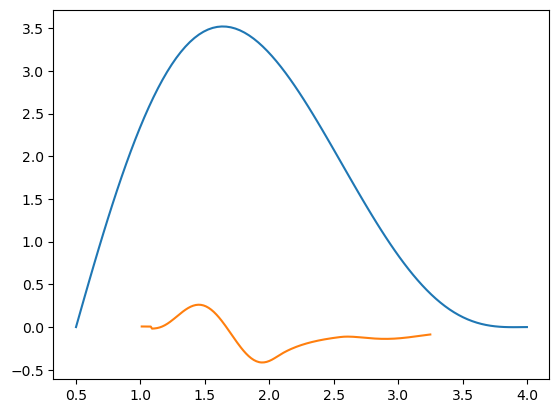

In [1055]:
r0 = 0.5
rc = 4

inst = Polynomial_Eam(r_0=r0, r_cutoff=4, n_knots=0)

y, dy, d2y = inst.rand_sample_points()

inst.fit_weights(y, dy, d2y)

x = np.linspace(r0,rc,100)

y = inst.predict(x)

k = 100

x_predict = whe[k:,0]

y_predict = inst.predict(x_predict)

x_test = whe[k:,0]

zbl = ZBL(Zi=74, Zj = 2)

y_test = whe[k:,1] - zbl.eval_zbl(whe[k:,0])

loss = inst.loss(y_predict, y_test)

plt.plot(x, y)
plt.plot(x_predict, y_test)

In [1056]:

knot_samples,loss_samples = inst.bayes_opt(100, x_test, y_test)


AttributeError: 'Polynomial_Eam' object has no attribute 'bayes_opt'

In [ ]:
np.logspace(-1,1, 5)

array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ])